In [65]:
import pandas as pd
from sklearn import decomposition
import matplotlib.pyplot as plt
import sklearn
import ast
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf

# Genre analysis

Let's import the data set that we are going to use for the analysis in this notebook.

In [66]:
df_movie = pd.read_csv("Expanded_data/big_data_final.tsv",sep='\t',low_memory=False)

In the next plot we want to give an idea of the different genres present in the data set.
Below we display the 20 most present genres.
We remark that drama, documentary and comedy movies are extremely present compared to other categories such as thriller movies.
We have to keep this into account when we do our analysis.

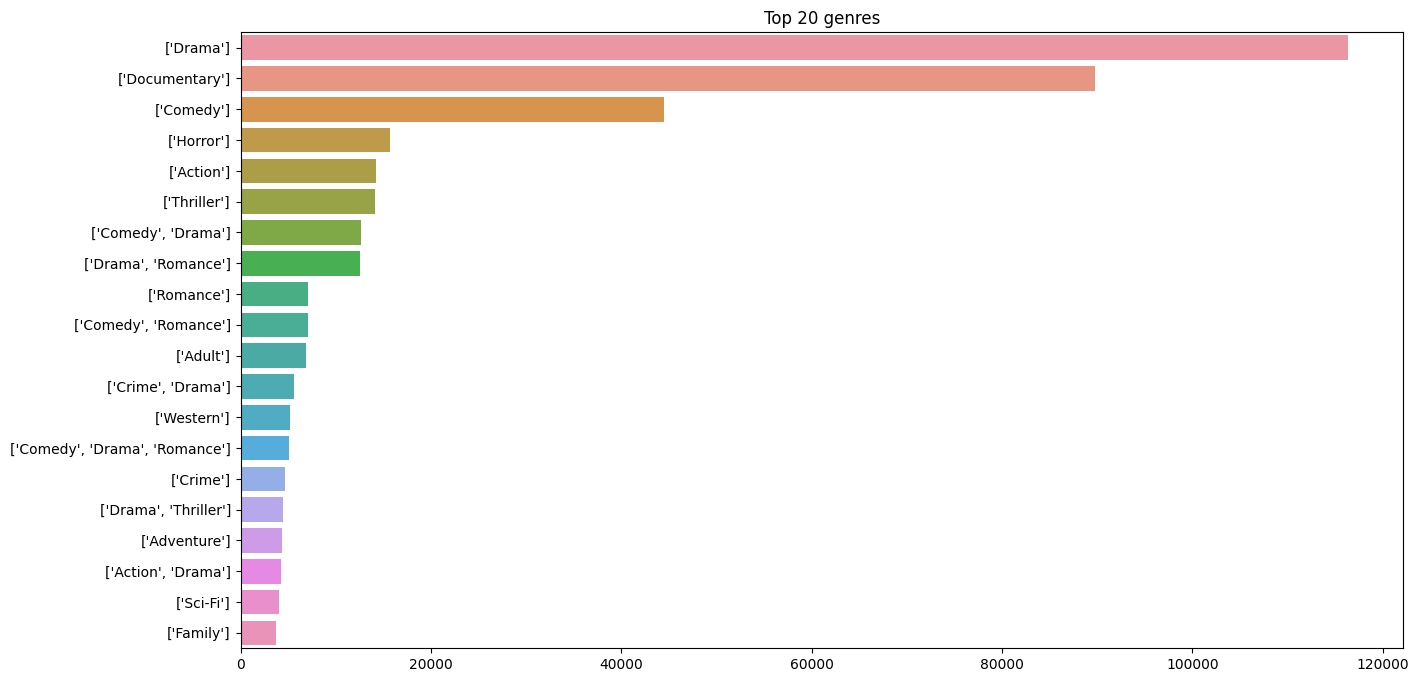

In [67]:
df_genre = df_movie.copy()
df_genre.dropna(subset=['Movie genres names'], inplace=True)
count_genre = df_genre['Movie genres names'].value_counts()
plt.figure(figsize=(15,8))
ax = sns.barplot(x=count_genre.values[0:20], y=count_genre.index[0:20]).set(title='Top 20 genres')
plt.show()

In [68]:
data = df_movie[['Movie genres names']].dropna()
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
counts = pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()
counts

Drama          225297
Documentary    117300
Comedy         106077
Action          52339
Romance         45960
Thriller        42906
Crime           35899
Horror          35347
Adventure       27349
Family          17170
Biography       16683
Mystery         16283
Fantasy         14782
History         13829
Sci-Fi          13419
Music           11871
Musical         10037
War              9126
Adult            8822
Animation        8607
Western          8096
Sport            6825
News             1441
Film-Noir         856
Reality-TV        488
Talk-Show         163
Short              57
Game-Show          28
dtype: int64

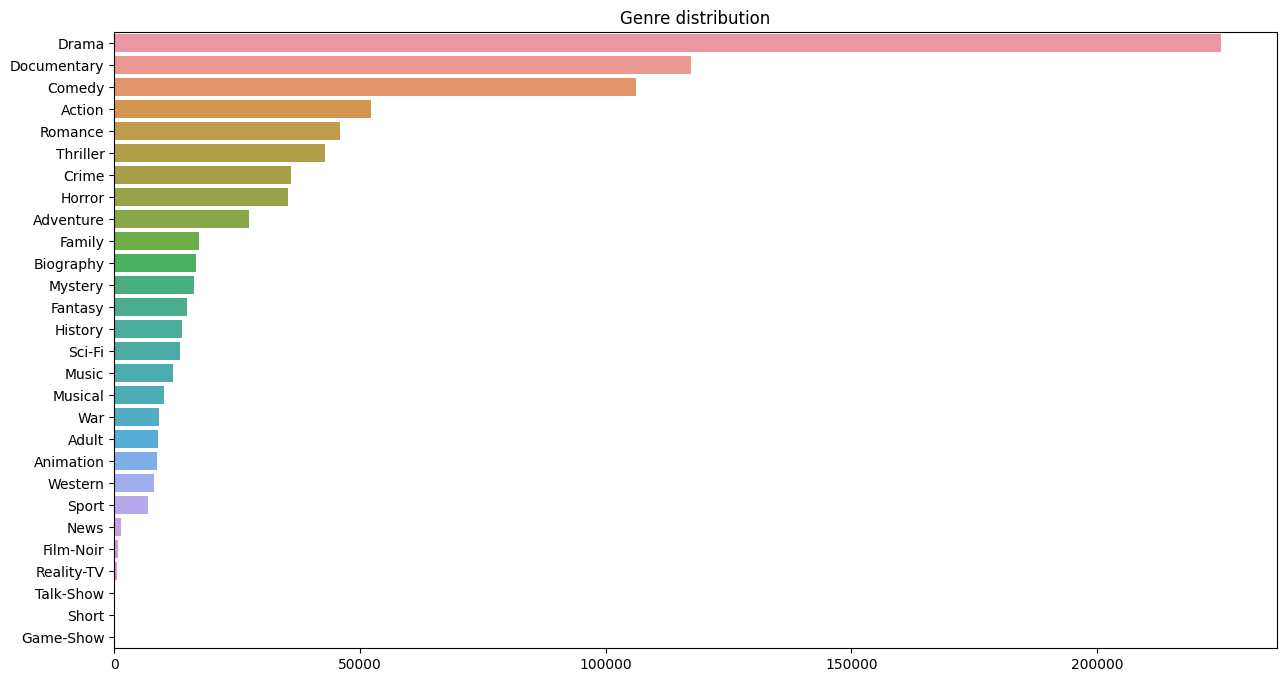

In [69]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=counts.values, y=counts.index).set(title='Genre distribution')
plt.show()

### 1) Data preprocessing: creation of dummies for genres

From the plot above we remark that some categories are actually an ensemble of several categories.
For example there is the category Commedy & Drama.
Here we want to split the genres in subunits of single genre. 
This can be done through the help of dummies.

For the analysis of this section, we are going to focus only on rating, budget and revenue.
This is way we can only keep these variables.

In [70]:
data = df_movie[['Movie genres names', 'averageRating', 'inflation corrected budget', 'inflation corrected revenue']].dropna()

If we recount the total number of movies in each category in the case of dummies, we remark that the total number of categories is 23.
The drama is leading with more that 2600 movies, followed by comedy and action.

In [71]:
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
counts = pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()
counts

Drama          2602
Comedy         1874
Action         1395
Crime          1021
Romance         905
Adventure       877
Thriller        870
Horror          592
Mystery         486
Fantasy         442
Sci-Fi          432
Biography       314
Family          250
History         177
Music           167
Sport           120
War             106
Musical          60
Animation        50
Western          45
Documentary      39
Adult             2
News              2
dtype: int64

Let's create the dummy variables.

In [72]:
def incorporate_genre_dummies(data):
    # transform into dummies
    movie_genres = [ast.literal_eval(movie_genre) for movie_genre in data['Movie genres names']]
    df = pd.get_dummies(pd.DataFrame(movie_genres))
    df.columns = df.columns.str.split("_").str[-1]

    # need to sum similarly named columns due to unwanted effect of previous computation
    df = df.groupby(level=0, axis=1).sum()
    genre_names = df.columns

    # adding to data and removing old genre column
    data[df.columns] = df.values
    #data = data.drop('Movie genres names', axis = 1)

    # rename problematic Sci-Fi column name
    data.rename(columns={'Sci-Fi' : 'SciFi'}, inplace = True)
    genre_names = [x if x != 'Sci-Fi' else 'SciFi' for x in genre_names]

    return data, genre_names

In [73]:
data, genre_names = incorporate_genre_dummies(data)

We rename some variables because of the notation of linear regression that we are going to use later.

In [74]:
#data.rename(columns={'inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)
data.rename(columns={'Movie genres names' : 'genre','inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)

Let's add columns for the logarithm of the revenue and budget.

In [75]:
data['log_revenue'] = np.log(data['corr_revenue'])
data['log_budget'] = np.log(data['corr_budget'])

In [76]:
data.head(2)

,genre,averageRating,corr_budget,corr_revenue,Action,Adult,Adventure,Animation,Biography,Comedy,...,Mystery,News,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget
33,"['Crime', 'Drama']",7.6,4.578426e+06,4.692887e+06,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15.361558,15.336866
225,"['Action', 'Comedy']",7.0,7.431127e+07,2.694641e+08,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,19.411946,18.123773


### 2) Genre distribution

Once we have prepared the dataset for the analysis we want to explore the genre distribution for rating, revenue and budget.

Below there are some functions that are going to be useful for looking that the distributions.

In [77]:
def bootstrap(data, n_it):
    means = np.zeros(n_it)
    data = np.array(data)
    
    for n in range(n_it):
        indices = np.random.randint(0, len(data), len(data))
        data_new = data[indices] 
        means[n] = np.nanmean(data_new)
    
    # 95% CI -> 2.5% and 97.5%
    return [np.nanmean(means), np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

def plot_CIs(CIs, params, xlabel=None):
    # function to plot confidence intervals
    # adapted code from solutions of tutorial 4

    # Compute interval center and half interval length for plotting
    means = np.array([CI[0] for CI in CIs])
    one_sided_CI = np.array([(CI[2] - CI[1]) / 2 for CI in CIs])

    # plot CIs
    plt.figure(figsize=(8,5))
    plt.errorbar(means, np.array(range(len(means))), xerr=one_sided_CI, linewidth=1,
                 linestyle='none', marker='o', markersize=3,
                 markerfacecolor='black', markeredgecolor='black', capsize=5)
    #plt.vlines(0, 0, len(means), linestyle='--')
    plt.yticks(range(len(params)), params);
    plt.xlabel(xlabel)
    plt.title('95% confidence intervals')
    plt.show()
    
def difference_in_usage(data_, g, CI_list, measure) :
    #difference returns -1 (absent for winner and present for the loser), 0 (present or absent in both), or 1 (present for the winner and absent for looser). 
    d = data_[data_[g]==1][measure]
    b = bootstrap(d, 1000)
    CI_list.append(b)

#### 2.1) Distribution of the rating across genre

In [78]:
def hist_subplots(measure, subtitle, xlabel, xlim, ylim):
    fig, axs = plt.subplots(6,4, constrained_layout=True, figsize=(20, 20))
    fig.suptitle(subtitle)

    axs[0,0].hist(data[measure], density=True)
    axs[0,0].set_title('All genres')
    axs[0,0].set_xlim(xlim)
    axs[0,0].set_ylim(ylim)
    axs[0,0].set(xlabel=xlabel, ylabel='Density')
    for i, g in enumerate(genre_names):
        i = i+1
        ax = axs[int(i/4),i%4]
        ax.hist(data[data[g]==1][measure], density=True)
        ax.set_title(g)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set(xlabel=xlabel, ylabel='Density')


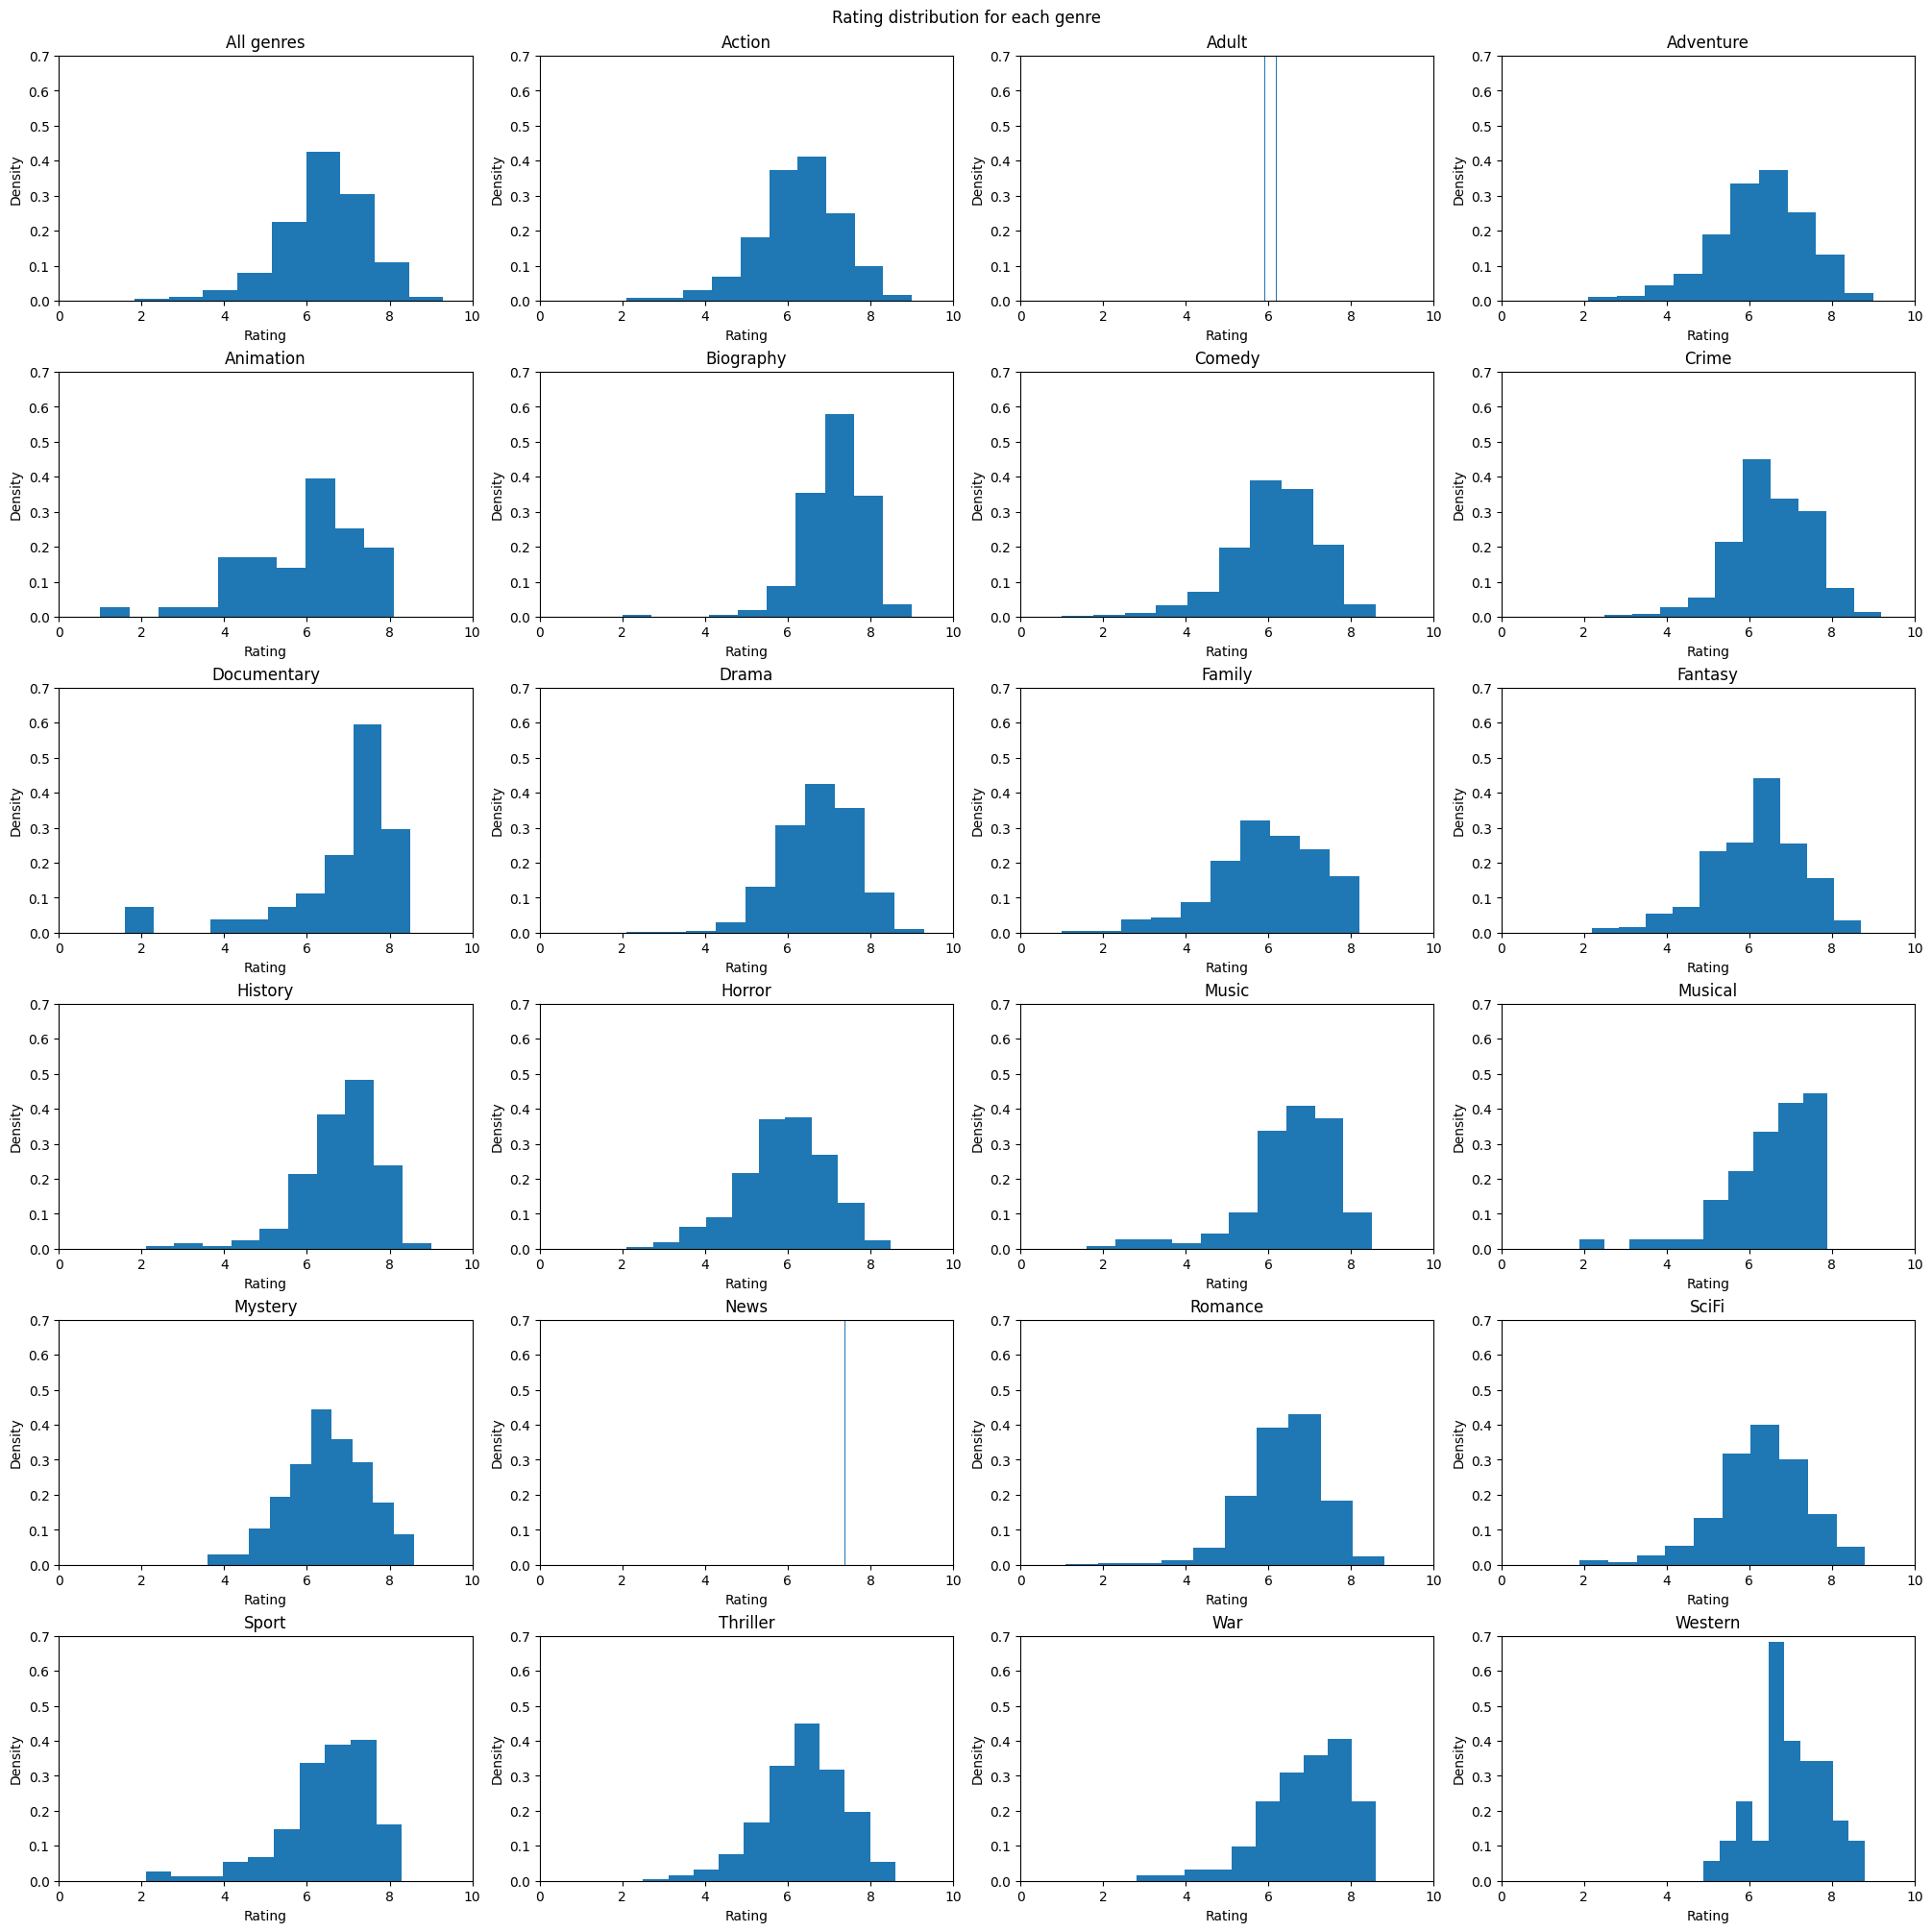

In [79]:
hist_subplots('averageRating', 'Rating distribution for each genre', 'Rating', (0,10), (0,0.7) )

We remark that in general the distributions seem to be heavy-tailed, with their maximum towords more positive rating.
We remind that the rating are in the range $[0,10]$, where $10$ is the maximum.

By looking that the plot of the mean value with the respecting 95% confidence interval, we see that some genres have mean value significantly different from each other.
Biography, news, war and wester seems to have higher mean values that the other categories.

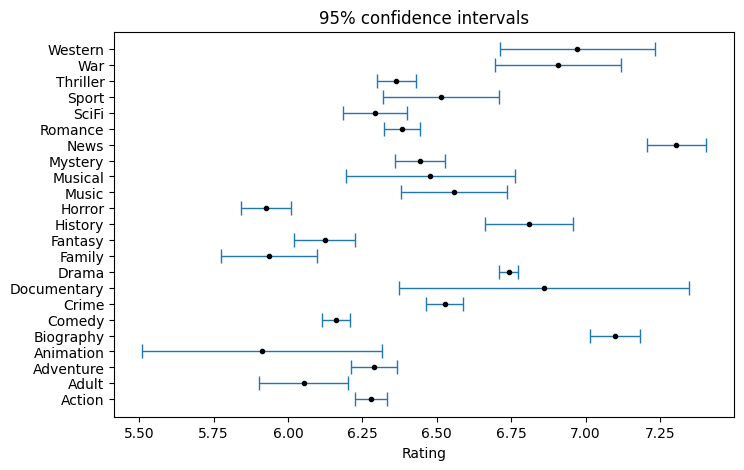

In [80]:
CIs = []    
    
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='averageRating')
    
plot_CIs(CIs, genre_names, 'Rating')

#### 2.2) Distribution of the budget across genre


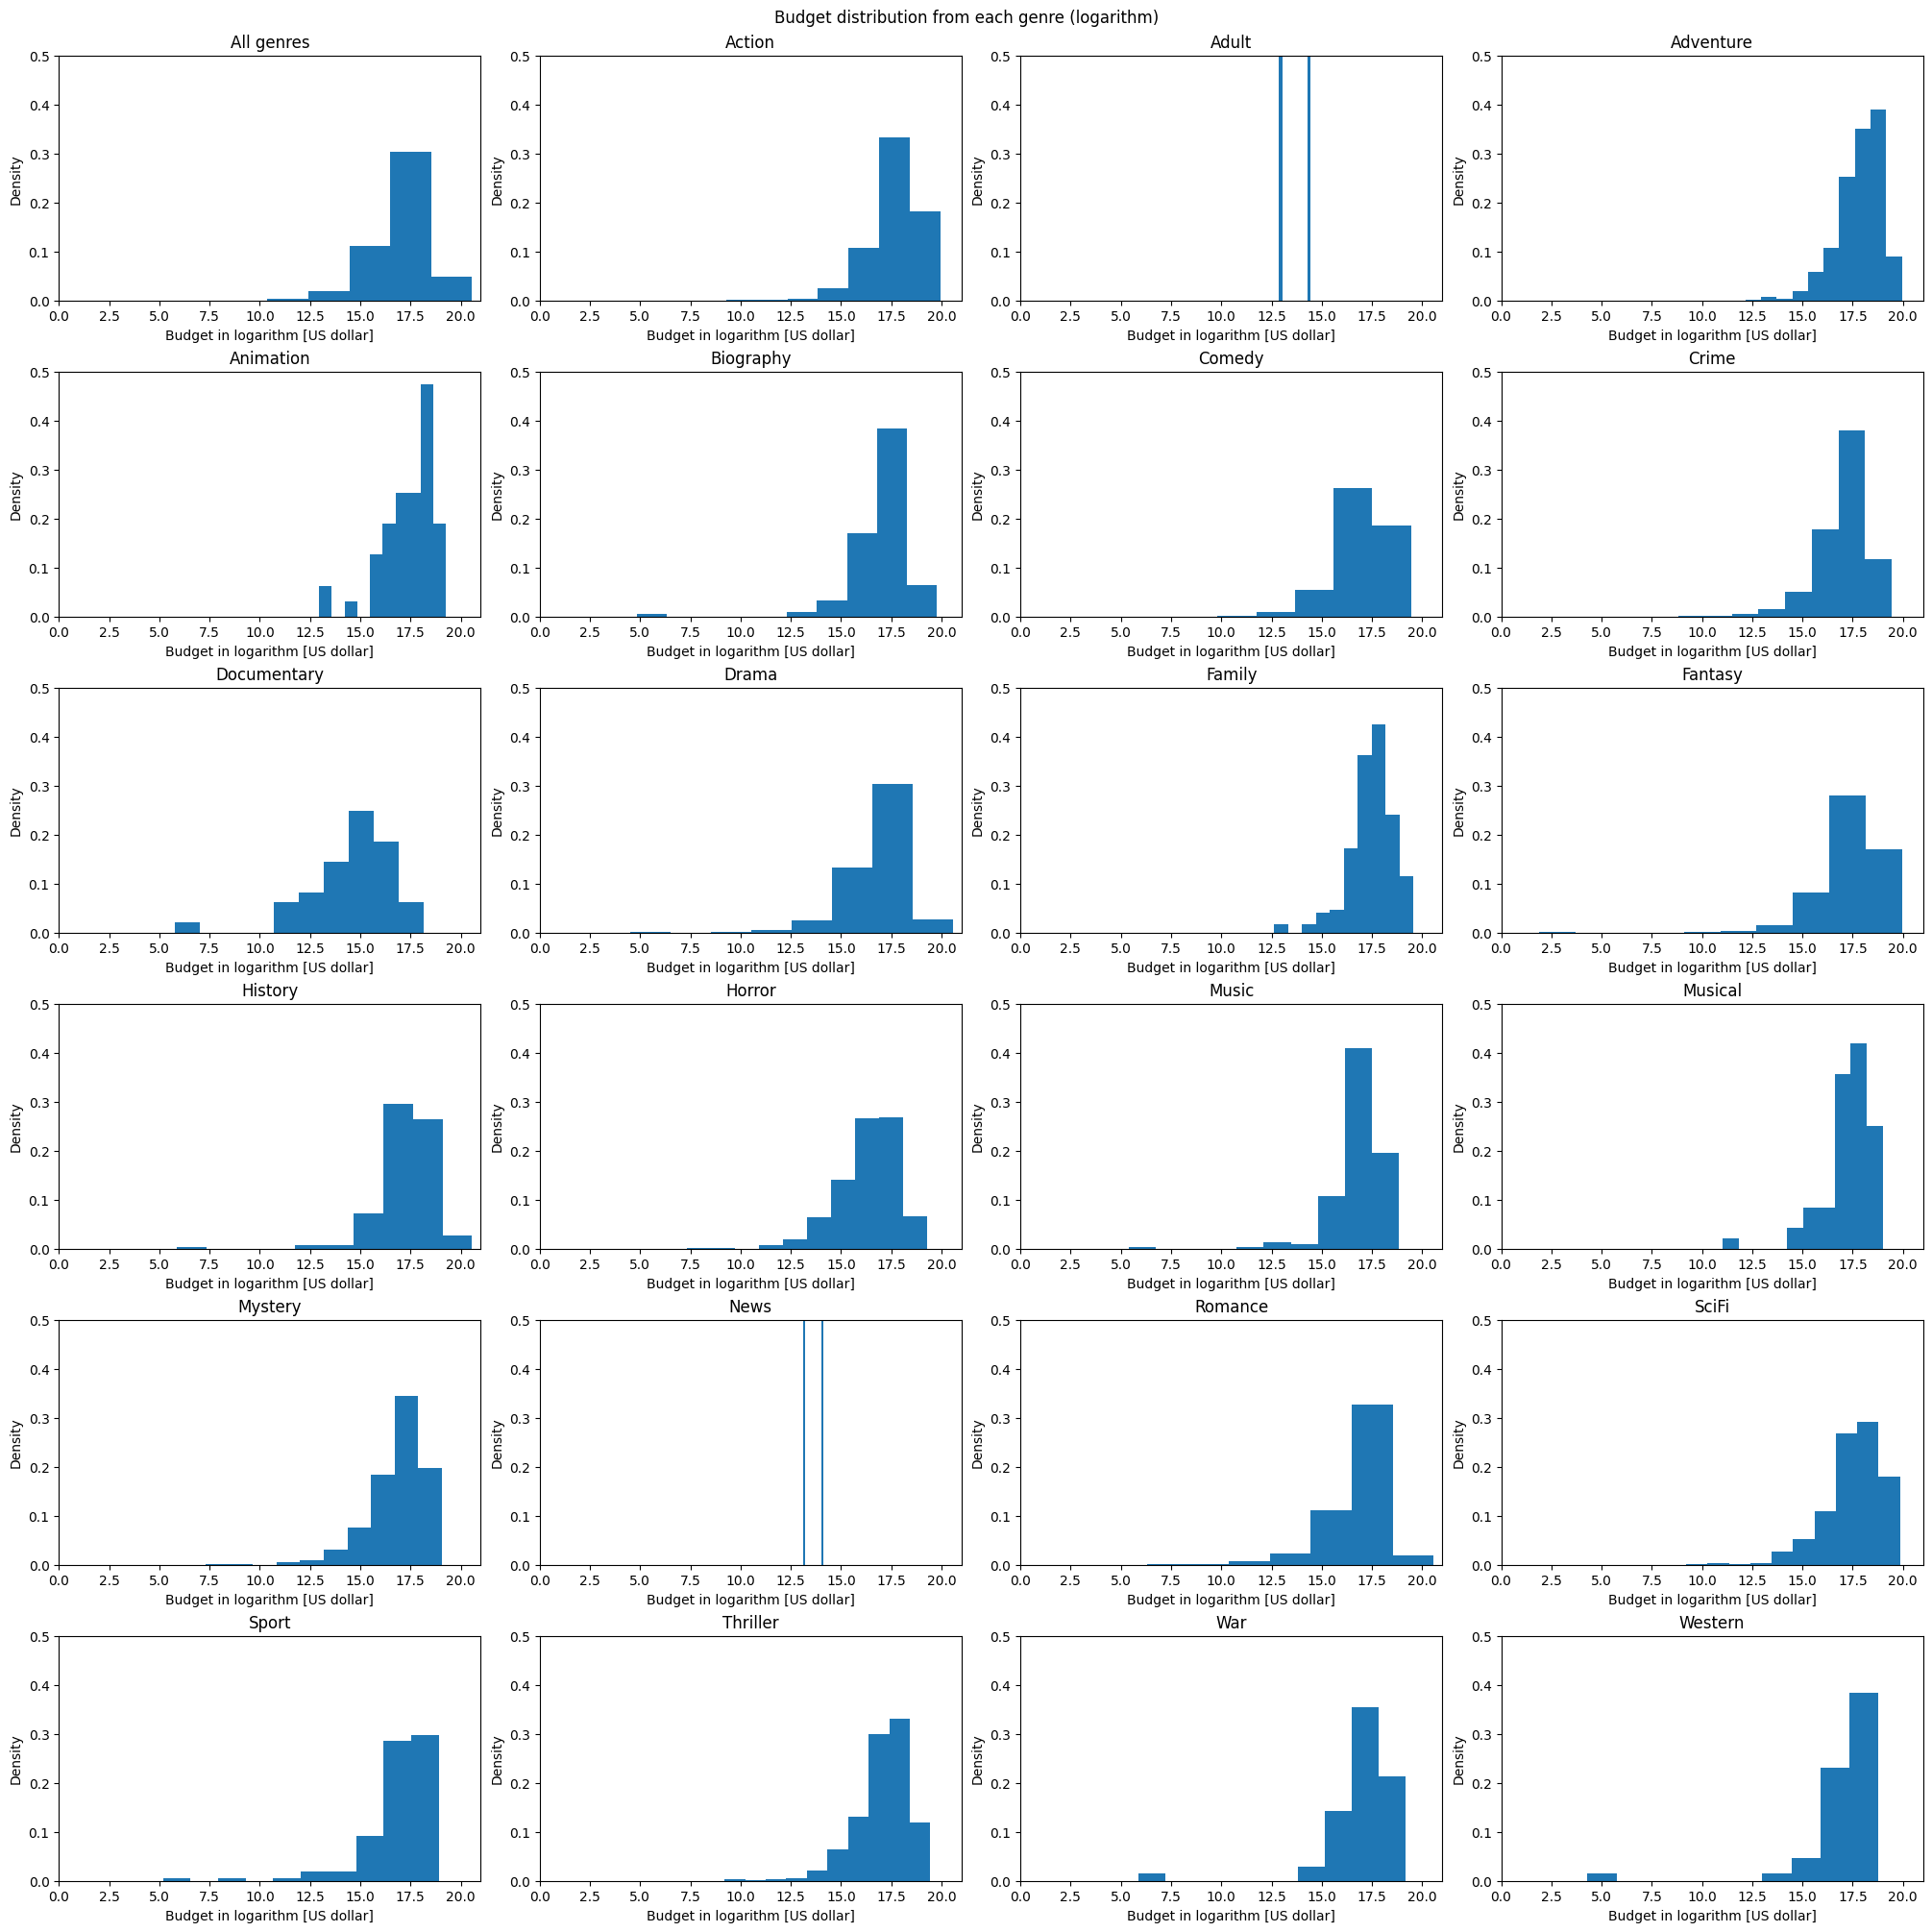

In [81]:
 hist_subplots('log_budget', 'Budget distribution from each genre (logarithm)', 'Budget in logarithm [US dollar]', (0,21), (0,0.5))

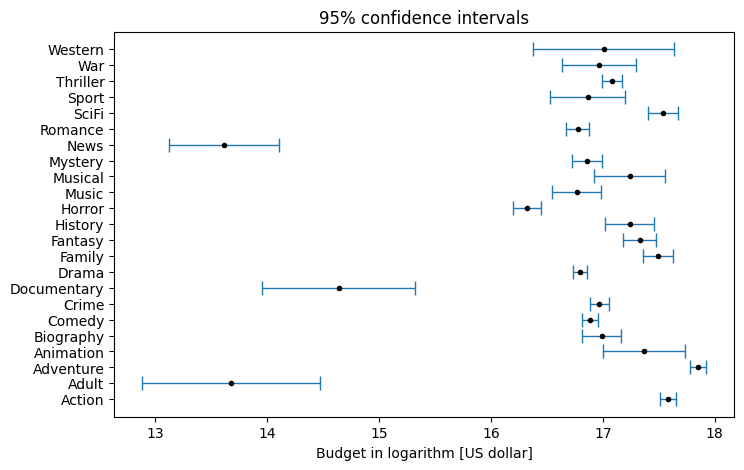

In [82]:
CIs = []
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='log_budget')
    
plot_CIs(CIs, genre_names, 'Budget in logarithm [US dollar]')

If we look that the mean value of the log budget, we remark that news, documentary and adult movies have low budgetcompared to all the others.

#### 2.3) Distribution of the revenue across genre


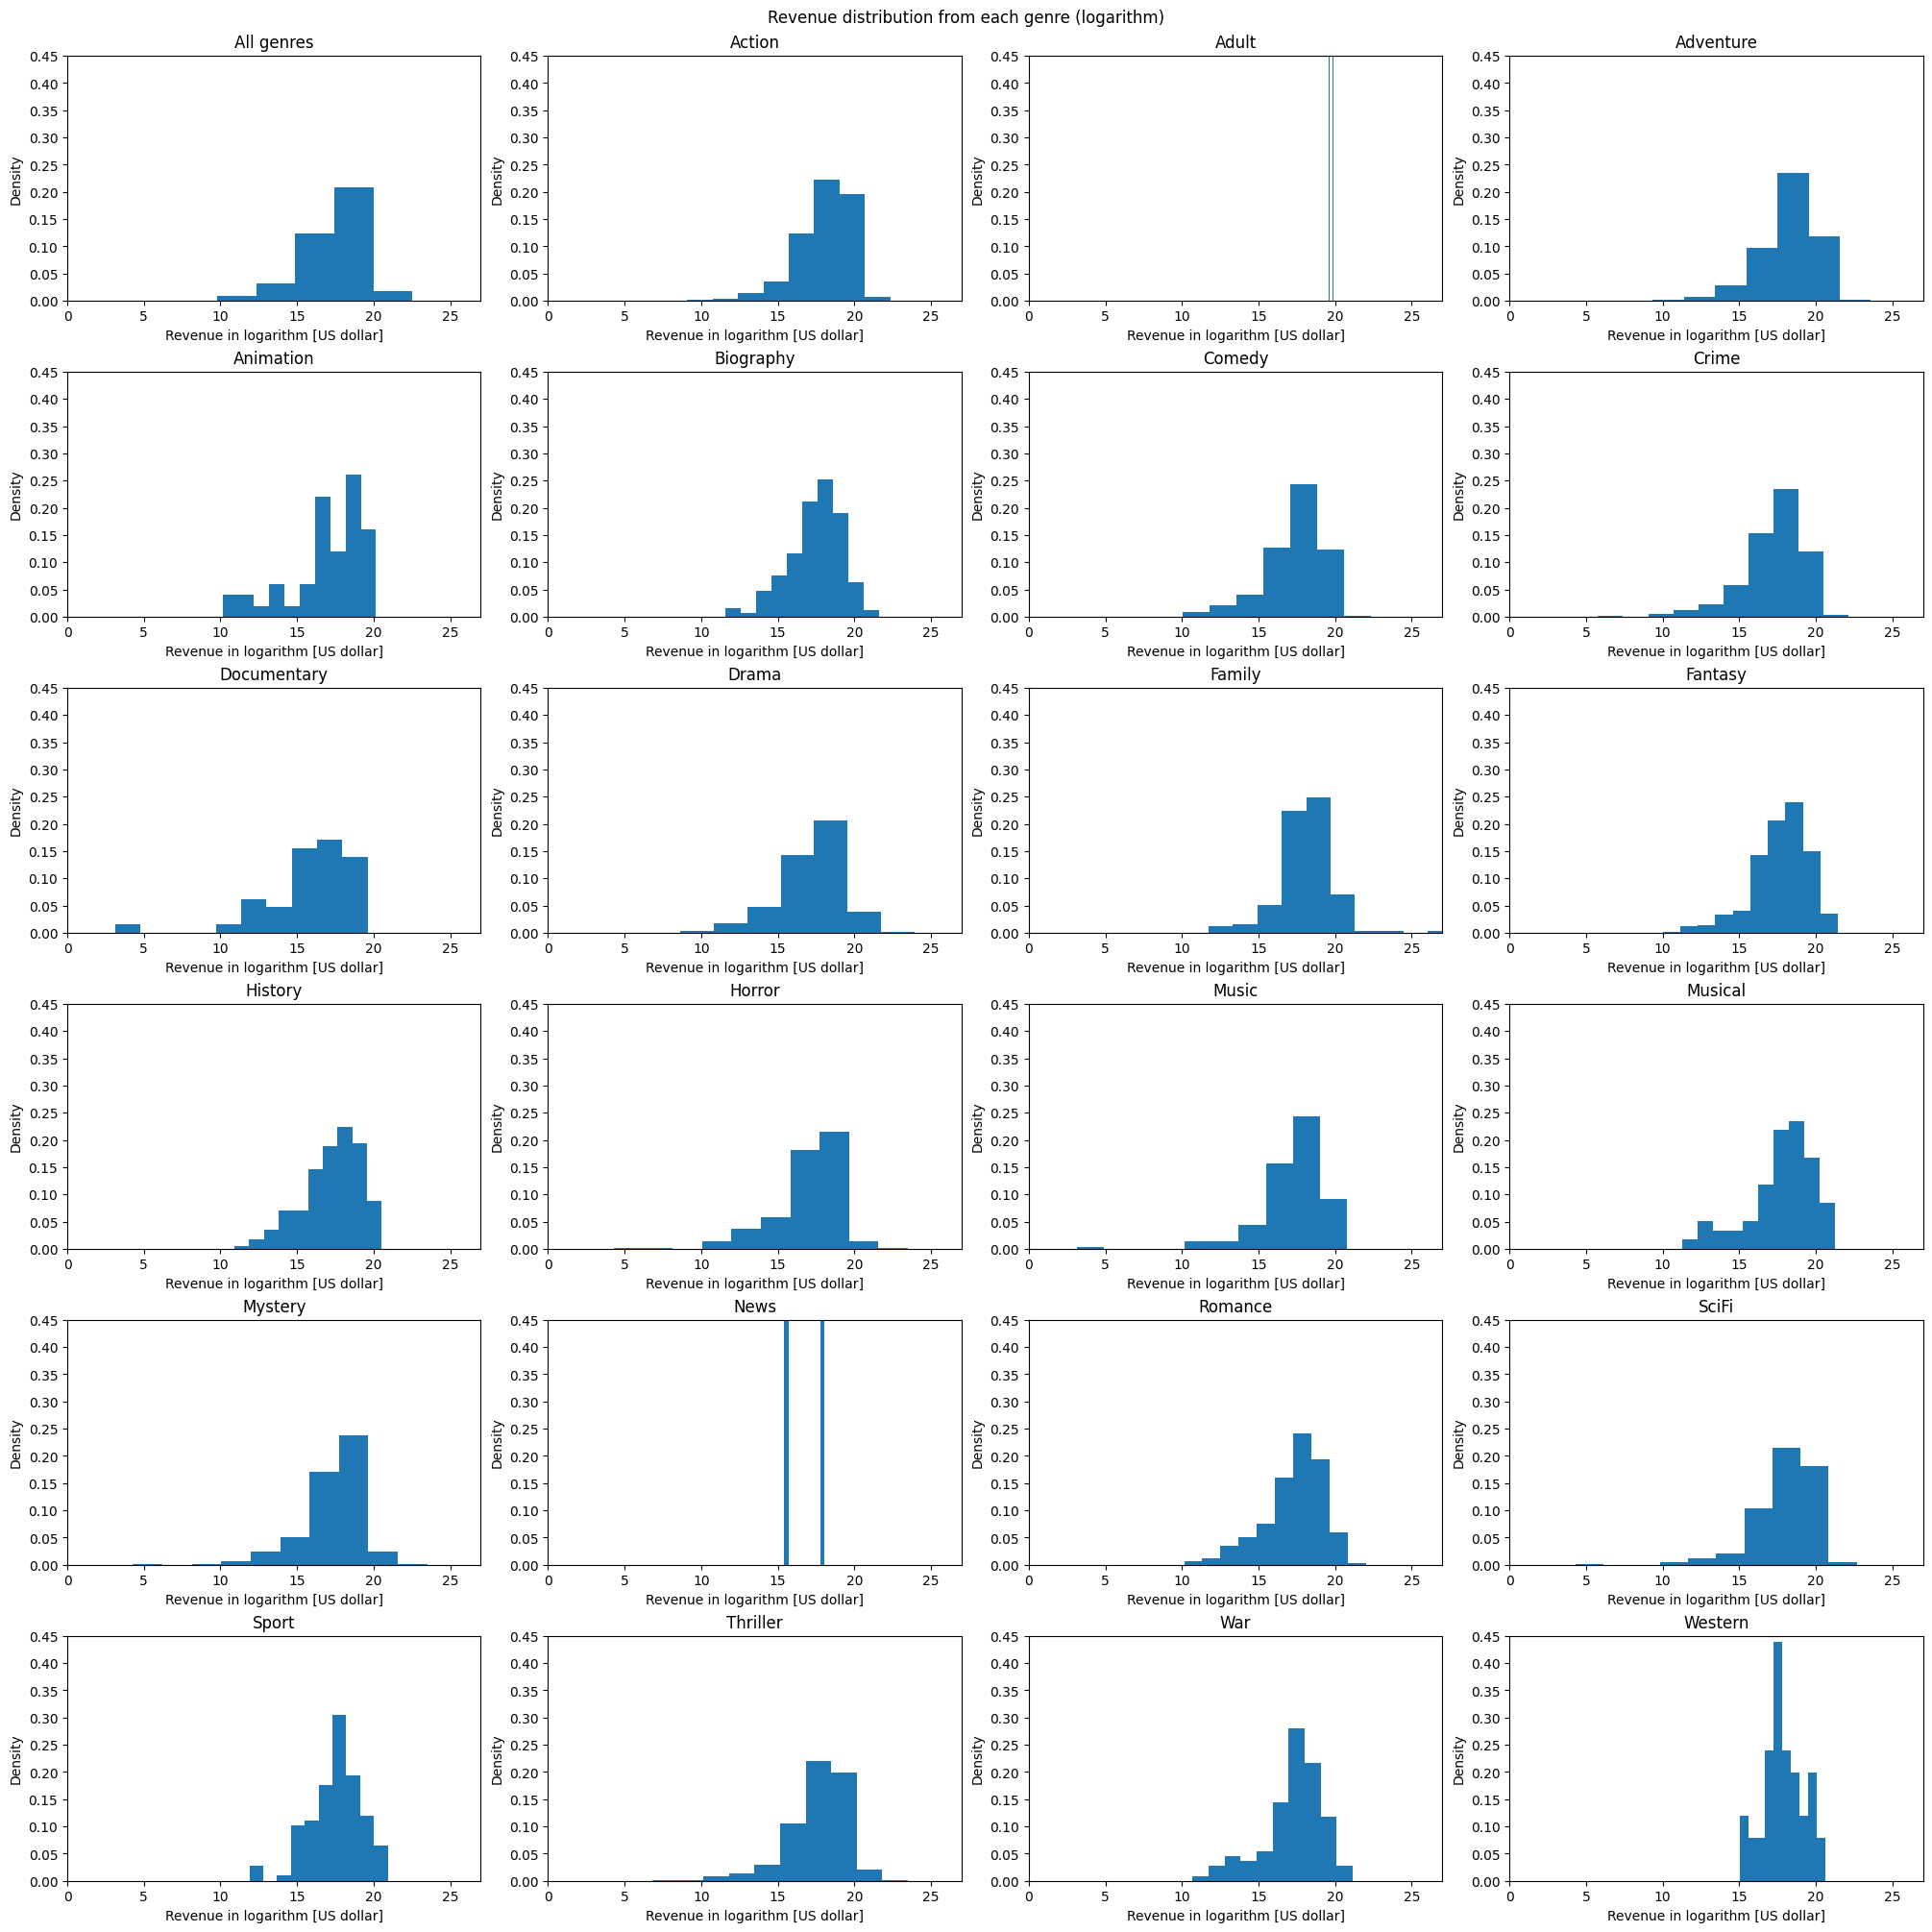

In [83]:
 hist_subplots('log_revenue', 'Revenue distribution from each genre (logarithm)', 'Revenue in logarithm [US dollar]', (0,27), (0,0.45))

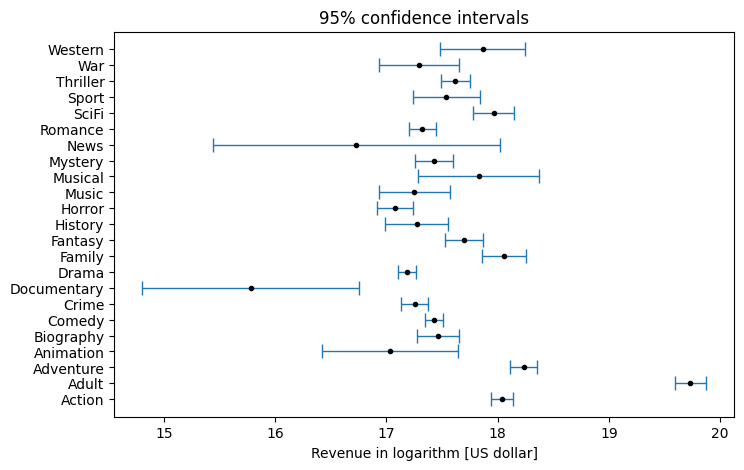

In [84]:
CIs = []
for g in genre_names:
    difference_in_usage(data, g=g, CI_list=CIs, measure='log_revenue')
    
plot_CIs(CIs, genre_names, 'Revenue in logarithm [US dollar]')

Adult movies seem to have extremely high revenue.
We also have to remember that the adult category had a very low budget. It seems that this genre can make a lot of money with a low budget. But from the rating analysis it was not the best rated category.

Let's now try to perform some linear regressions in order to predict our variables of interest, rating and revenue, with the help of the genre and the budget.

### 3) Linear regression: average ratings and revenue

Here we create a function that is going to be useful for the visualisation of the coefficient of the linear regressions.

In [85]:
def barplot(res, figsize=(5,7)) :
    ''' Barplot of the coefficients of the linear regression sorted by value'''
    tmp = []
    for name, value in zip(res.params.index, res.params):
        tmp.append({"name": name, "value": value})

    features_coef = pd.DataFrame(tmp).sort_values("value")

    plt.subplots(figsize=figsize)
    plt.barh(features_coef.name, features_coef.value, alpha=0.6)
    plt.show()


#### 3.1) Rating in function of the genres

We want to try to linearly predict the rating based on the genre.

In [86]:
mod = smf.ols(formula="averageRating ~ Action + Adult + Adventure +\
       Animation + Biography + Comedy + Crime + Documentary + Drama +\
       Family + Fantasy + History + Horror + Music + Musical + Mystery +\
       News + Romance + SciFi + Sport + Thriller + War + Western", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     40.79
Date:                Fri, 09 Dec 2022   Prob (F-statistic):          3.18e-167
Time:                        16:40:40   Log-Likelihood:                -6940.1
No. Observations:                5018   AIC:                         1.393e+04
Df Residuals:                    4994   BIC:                         1.408e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.4053      0.061    105.449      

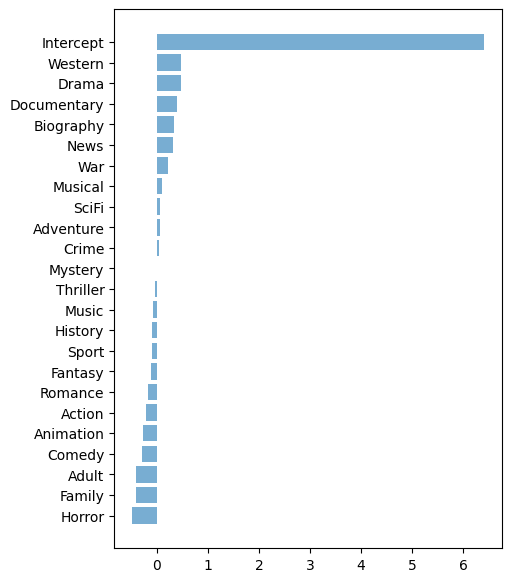

In [87]:
barplot(res)

**Biography, Documentary, Drama, Western** are significantly driving the grades upwards, while **Action, Comedy, Family, Horror and Romance** drive it downwards.
We have to remark that the R square of this regression is very low, not even 0.2. The model does not describe well our response variable.

But what if we keep the genre together without using dummies varibles?

In [88]:
mod = smf.ols(formula="averageRating ~ genre", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:          averageRating   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.202
Method:                 Least Squares   F-statistic:                     4.608
Date:                Fri, 09 Dec 2022   Prob (F-statistic):          4.60e-132
Time:                        16:40:41   Log-Likelihood:                -6621.4
No. Observations:                5018   AIC:                         1.395e+04
Df Residuals:                    4664   BIC:                         1.626e+04
Df Model:                         353                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

We obtain a higher R squre! The genre not split better capture the rating!

#### 3.2) Log revenue in function of the genre

We can perform the same analysis of before but the the logarithm of the revenue as response variable.
The result is presented below.

In [89]:
mod = smf.ols(formula="log_revenue ~ Action + Adult + Adventure + \
       Animation + Biography + Comedy + Crime + Documentary + Drama +\
       Family + Fantasy + History + Horror + Music + Musical + Mystery +\
       News + Romance + SciFi + Sport + Thriller + War + Western", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     19.32
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           5.94e-76
Time:                        16:40:41   Log-Likelihood:                -10446.
No. Observations:                5018   AIC:                         2.094e+04
Df Residuals:                    4994   BIC:                         2.110e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      17.0124      0.122    139.258      

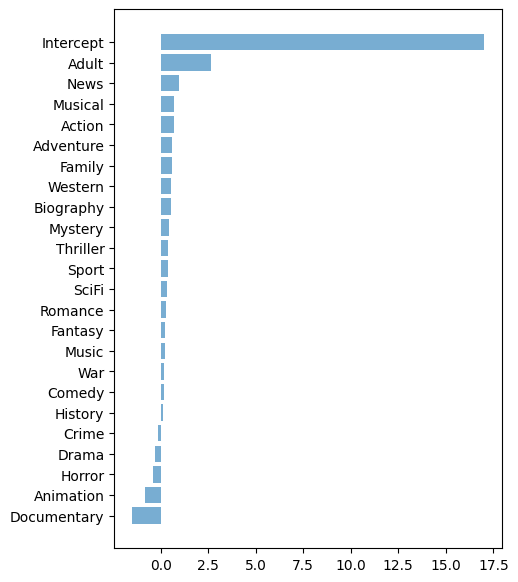

In [90]:
barplot(res)

**Action, Adventure, Biography, Family, Mystery, Thriller** are significantly driving the revenue upwards, while **Animation, Documentary, Drama and Horror** drive it downwards.
Again the R squared is very low, even lower than for the case of the rating.
This model does not predict our response variable.

It seems that the genre is not helpful to linearly predict the rating and the log revenue.

Some genres have a similar effect on rating and revenue, like **Biography (upward) and Horror (downward)**. While **Action** movies are generally associated to a bad movie, it paradoxically generates a lot of revenue. On the contrary, while **Documentaries** are well graded, they produce little revenue.
Let's try to captue this in one regression using interactions.

In [91]:
mod = smf.ols(formula="log_revenue ~ Comedy*Romance + \
                                    Comedy*Drama + \
                                    Drama*Romance ", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     21.50
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           4.52e-25
Time:                        16:40:41   Log-Likelihood:                -10596.
No. Observations:                5018   AIC:                         2.121e+04
Df Residuals:                    5011   BIC:                         2.125e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         17.9105      0.058    308.

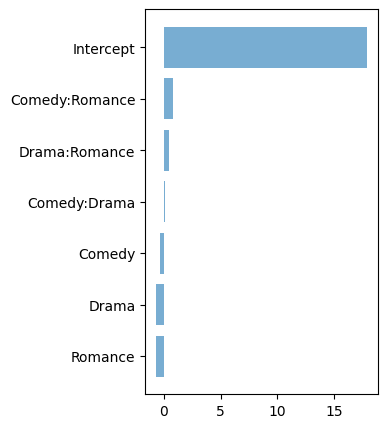

In [92]:
barplot(res, figsize=(3,5))

Interestingly, for very common genre associations, we observe that their combination has a positive effect on revenue, while the genre alone tend to provoke a decrease. But the R value decreased.

Again let's try to use the original genres:

In [93]:
mod = smf.ols(formula="log_revenue ~ genre ", data=data)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            log_revenue   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     2.736
Date:                Fri, 09 Dec 2022   Prob (F-statistic):           8.36e-51
Time:                        16:40:41   Log-Likelihood:                -10188.
No. Observations:                5018   AIC:                         2.108e+04
Df Residuals:                    4664   BIC:                         2.339e+04
Df Model:                         353                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

Again, the R squred is much higher! It  is better to use to original genre.

### Boxplots

In [94]:
budget, revenue, rating = list(), list(), list()
for genre in genre_names:
    budget.append(data[data[genre] == 1]['log_budget'])
    revenue.append(data[data[genre] == 1]['log_revenue'])
    rating.append(data[data[genre] == 1]['averageRating'])

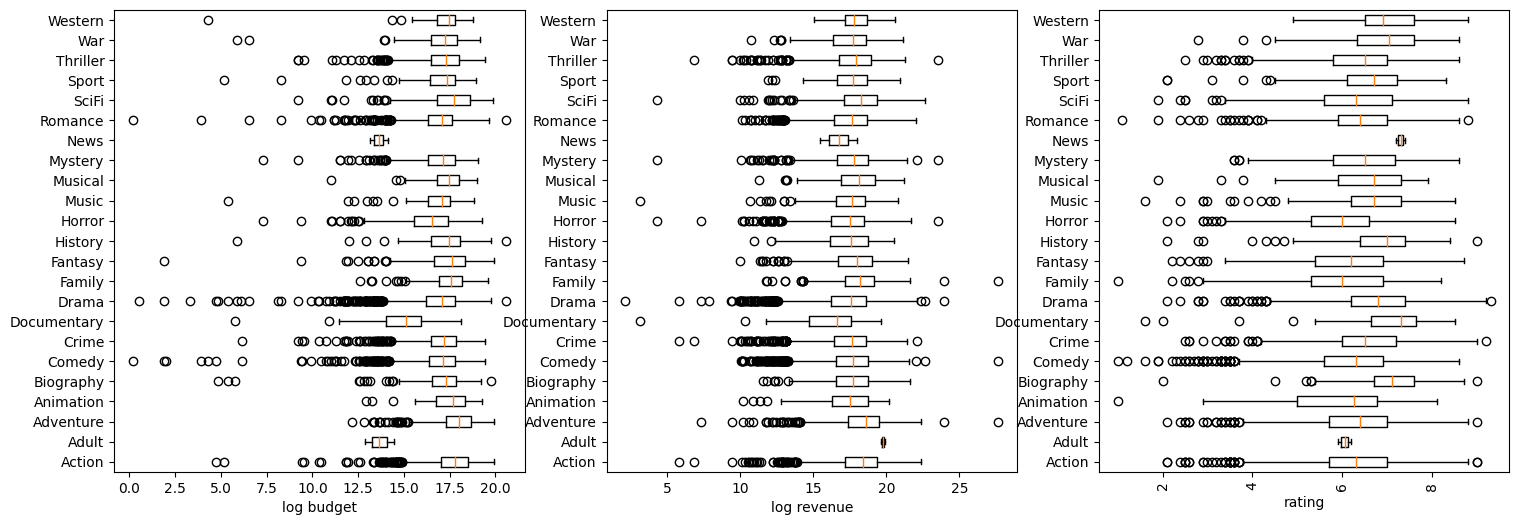

In [95]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(18,6))
axs[0].boxplot(budget, labels=genre_names, vert = False)
axs[0].set_xlabel('log budget')
axs[1].boxplot(revenue, labels=genre_names, vert = False)
axs[1].set_xlabel('log revenue')
axs[2].boxplot(rating, labels=genre_names, vert = False)
axs[2].set_xlabel('rating')
plt.xticks(rotation=90)
plt.show()

Useful ?

### 4) Low budget and high revenue
#### Scatter plot

Let's try to look at region where the budget il low and the revenue is high.
For this we use a linear regression and we select a threshold for detecting the low budget.

In [96]:
mod = smf.ols(formula="log_revenue ~ log_budget ", data=data)
res = mod.fit()

In [97]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_revenue   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     1896.
Date:                Fri, 09 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:40:42   Log-Likelihood:                -9855.8
No. Observations:                5018   AIC:                         1.972e+04
Df Residuals:                    5016   BIC:                         1.973e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0981      0.262     23.296      0.000       5.585       6.611
log_budget     0.6692      0.015     43.540      0.000       0.639       0.699
==============================================================================
Omnibus:                     1071.258   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7204.999
Skew:                          -0.849   Prob(JB):                         0.00
Kurtosis:                       8.619   Cond. No.                         184.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [98]:
coef = res.params.values

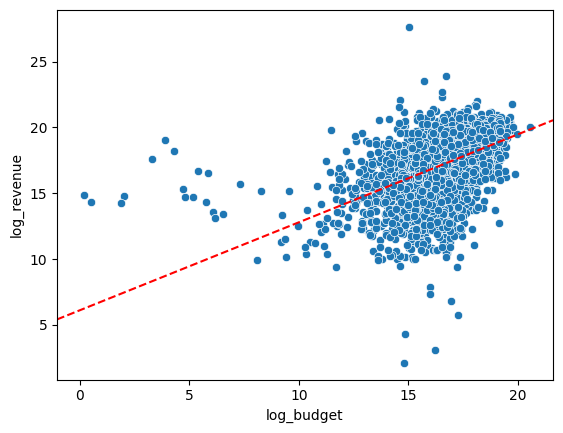

In [99]:
fig = sns.scatterplot(x=data.log_budget,y=data.log_revenue)
fig.axline((0,coef[0]), slope=coef[1], color='red', label='Linear fit',linestyle='dashed')
plt.show()

Let's select the movies with log budget lower than 7. 
In this region we see that all the movies are above the regression line, therefore they have a quite high revenue compared to the budget.

In [100]:
low_budget = data.loc[data.log_budget <= 7]

In [101]:
df = low_budget.copy()
df = df.drop(columns = ['genre','averageRating','corr_budget','corr_revenue','log_revenue','log_budget'])

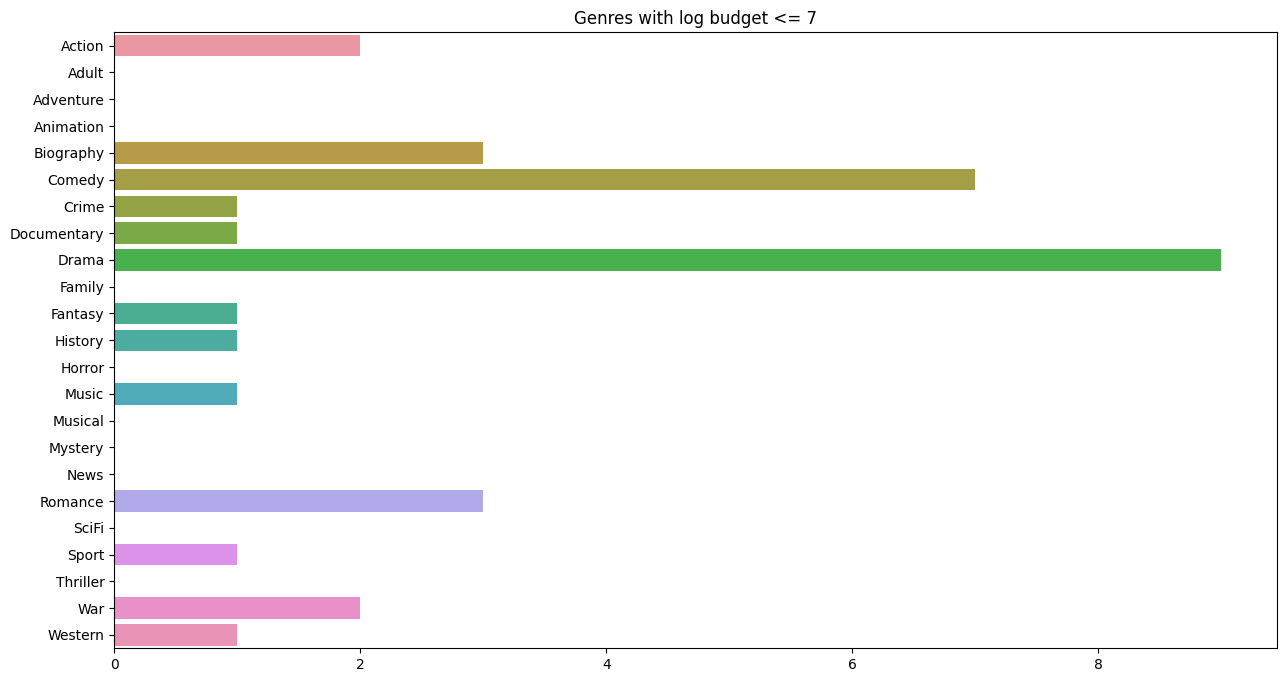

In [102]:
genres = df.columns
tot = []
for gen in genres:
    tot.append(sum(df[gen]))
plt.figure(figsize=(15,8))
ax = sns.barplot(x=tot, y=genres).set(title='Genres with log budget <= 7')
plt.show()

Above we see a representation of the genre in the case of low budget.
There are a lot of drama movies, this could be due by the fact that there are a lot of drama movies in the datset.
By dividing the values here by the total number of movie sin each categories we should see a bit better the situation.

In [103]:
all_tot = []
for gen in genres:
    all_tot.append(sum(data[gen]))

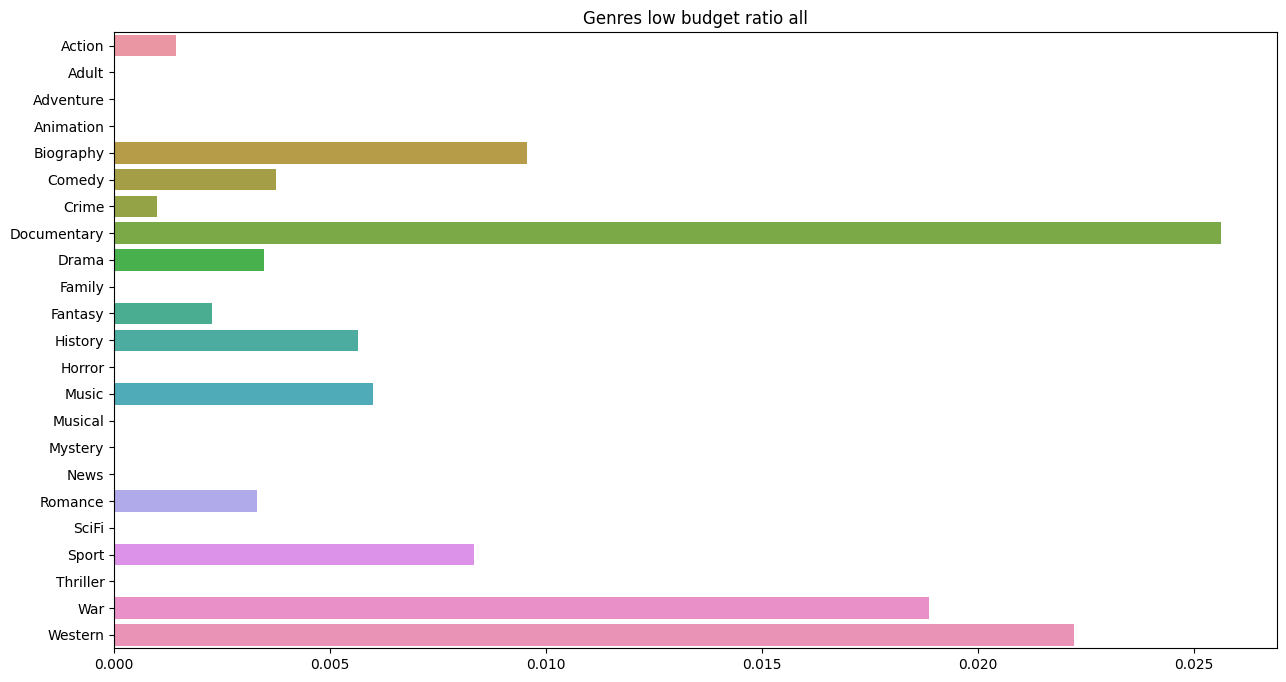

In [104]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=np.array(tot)/np.array(all_tot), y=genres).set(title='Genres low budget ratio all')
plt.show()

Now it seems that documentary and western are quite present in this low budget region.

We focused on low budget movies but now we can also try to look at movies that earn 10 times more than their budget.

In [105]:
high_revenue = data.loc[data.log_revenue >= (np.log(10) + data.log_budget)]
#high_revenue = data.copy()

In [106]:
df = high_revenue.copy()
df = df.drop(columns = ['genre','averageRating','corr_budget','corr_revenue','log_revenue','log_budget'])

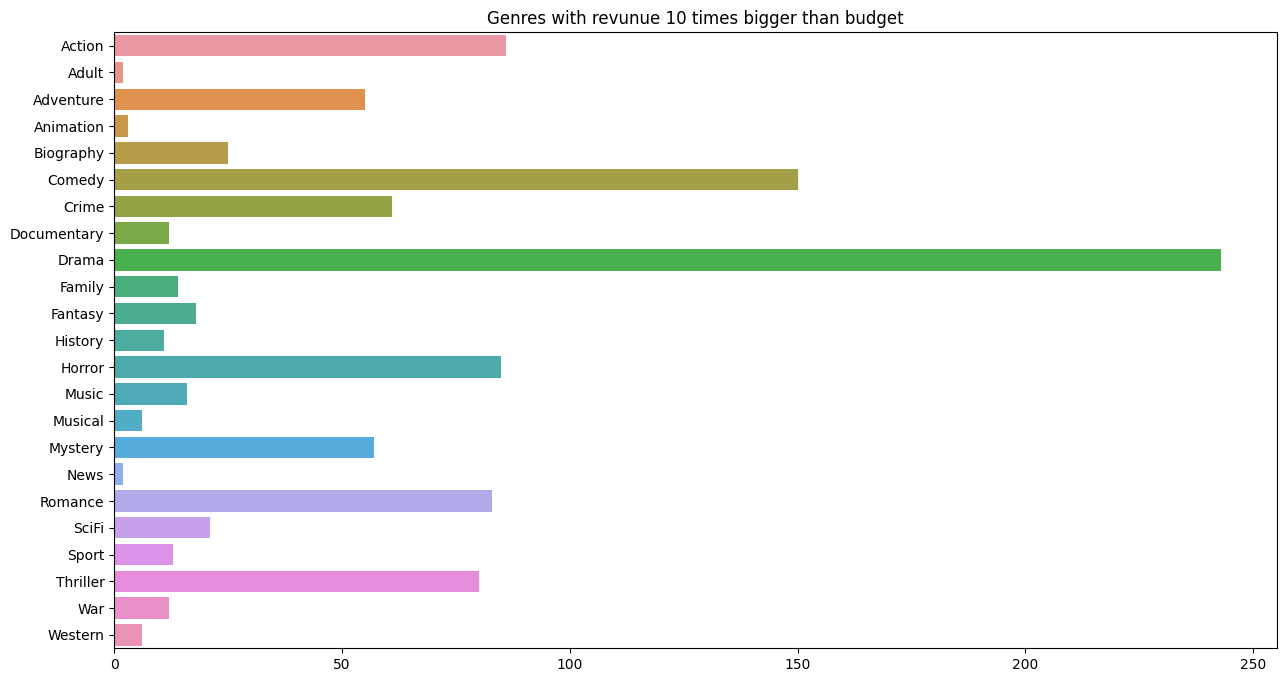

In [107]:
genres = df.columns
tot = []
for gen in genres:
    tot.append(sum(df[gen]))
plt.figure(figsize=(15,8))
ax = sns.barplot(x=tot, y=genres).set(title='Genres with revunue 10 times bigger than budget')
plt.show()

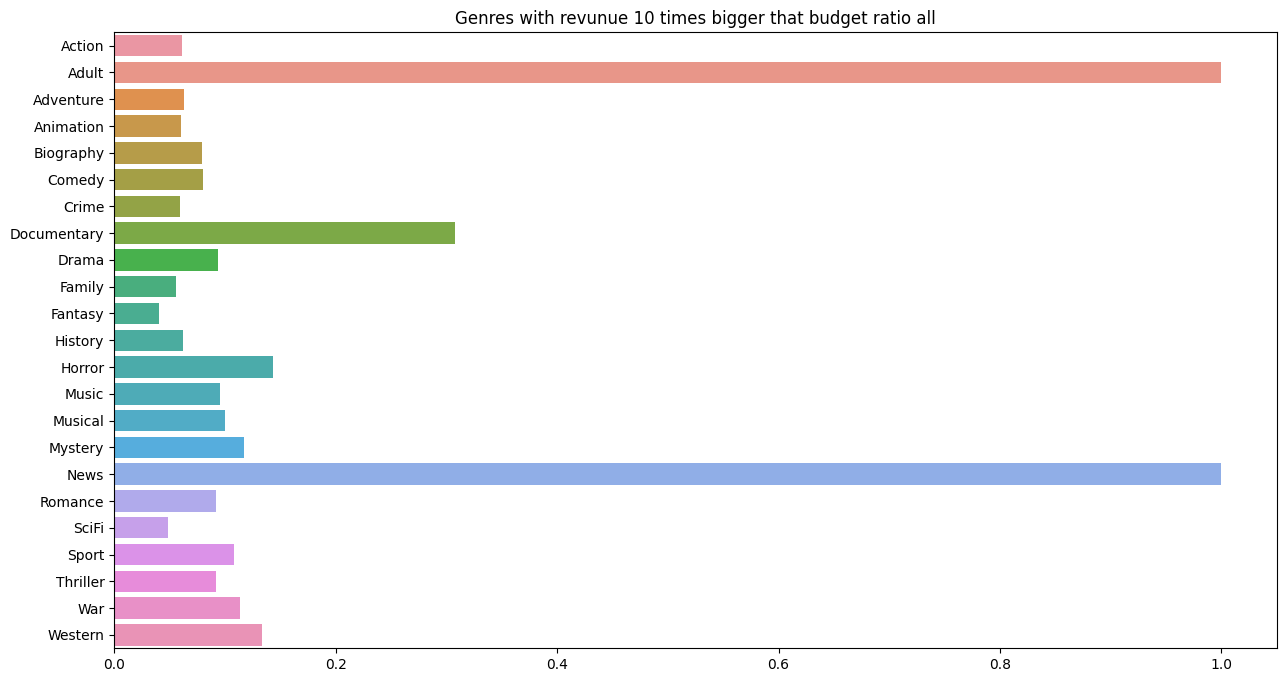

In [108]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x=np.array(tot)/np.array(all_tot), y=genres).set(title='Genres with revunue 10 times bigger that budget ratio all')
plt.show()

Among these super revenue movies there are adult and news movies.
Actually all the movies in the category adult, only 2 unfortunately, have very low budget and very high revenue. 
The same happens for the news movie.
We also remark that documentary shows this pattern, but with less strenght.

# Genre across time
We want to observe if some evolution occurs across time.

In [109]:
data_time = df_movie[['Movie genres names', 'Movie release date', 'averageRating', 'inflation corrected budget', 'inflation corrected revenue']].dropna()
data_time, genre_names = incorporate_genre_dummies(data_time)
data_time.rename(columns={'Movie genres names' : 'genre', 'Movie release date':'date', 'inflation corrected revenue' : 'corr_revenue', 'inflation corrected budget' : 'corr_budget'}, inplace = True)
data_time['log_revenue'] = np.log(data_time['corr_revenue'])
data_time['log_budget'] = np.log(data_time['corr_budget'])
data_time.head()

,genre,date,averageRating,corr_budget,corr_revenue,Action,Adult,Adventure,Animation,Biography,...,Mystery,News,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget
33,"['Crime', 'Drama']",2014.0,7.6,4.578426e+06,4.692887e+06,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15.361558,15.336866
225,"['Action', 'Comedy']",2015.0,7.0,7.431127e+07,2.694641e+08,1,0,0,0,0,...,0,0,0,0,0,0,0,0,19.411946,18.123773
446,['Comedy'],2014.0,6.7,3.891662e+06,1.236175e+06,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14.027532,15.174347
470,"['Action', 'Adventure', 'Drama']",2015.0,8.0,1.543388e+08,6.092958e+08,1,0,1,0,0,...,0,0,0,0,0,0,0,0,20.227814,18.854661
492,"['Crime', 'Drama', 'Mystery']",2015.0,7.8,5.030301e+07,1.780728e+08,0,0,0,0,0,...,1,0,0,0,0,0,0,0,18.997703,17.733576


In [110]:
# split data in two periods: from 1959 to 2000 and from 2000 to 2021.
old_movies = data_time[data_time.date < 2000]
recent_movies = data_time[data_time.date >= 2000]

In [111]:
# number of movie genres in the first period (before 2000)
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in old_movies.genre]
pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()

Drama          1056
Comedy          793
Action          512
Crime           453
Thriller        371
Romance         356
Adventure       324
Horror          261
Mystery         183
Sci-Fi          174
Fantasy         172
Biography       104
Family          103
Music            73
History          61
War              56
Sport            53
Western          33
Musical          27
Animation         7
Documentary       4
Adult             2
dtype: int64

In [112]:
# number of movie genres in the second period (after 2000 included)
movie_genres = [ast.literal_eval(movie_genre) for movie_genre in recent_movies.genre]
pd.Series([genre for sublist in movie_genres for genre in sublist]).value_counts()

Drama          1546
Comedy         1081
Action          883
Crime           568
Adventure       553
Romance         549
Thriller        499
Horror          331
Mystery         303
Fantasy         270
Sci-Fi          258
Biography       210
Family          147
History         116
Music            94
Sport            67
War              50
Animation        43
Documentary      35
Musical          33
Western          12
News              2
dtype: int64

Here, the first popular genres seem to be similar. Indeed, Drama, Comedy, Action and Crime remain all the 4 more represented movie genres in both periods. 

In [113]:
# useful function
def plot_double_CIs(CIs_t1, CIs_t2, params, xlabel=None):
    # function to plot confidence intervals
    # adapted code from solutions of tutorial 4

    # create figure
    plt.figure(figsize=(10,8))

    # Compute interval center and half interval length for plotting for t1
    means = np.array([CI[0] for CI in CIs_t1])
    one_sided_CI = np.array([(CI[2] - CI[1]) / 2 for CI in CIs_t1])

    # plot CIs
    l1 = plt.errorbar(means, np.array(range(len(means))) + 0.2, xerr=one_sided_CI, linewidth=1,
                 linestyle='none', marker='o', markersize=3,
                 markerfacecolor='black', markeredgecolor='black', capsize=5)

    # Compute interval center and half interval length for plotting for t2
    means = np.array([CI[0] for CI in CIs_t2])
    one_sided_CI = np.array([(CI[2] - CI[1]) / 2 for CI in CIs_t2])

    # plot CIs
    l2 = plt.errorbar(means, np.array(range(len(means))) - 0.1, xerr=one_sided_CI, linewidth=1,
                 linestyle='none', marker='o', markersize=3,
                 markerfacecolor='black', markeredgecolor='black', capsize=5)
    
    plt.yticks(range(len(params)), params);
    plt.xlabel(xlabel)
    plt.title('95% confidence intervals')
    plt.legend([l1, l2], ['old', 'recent'])


C:\Users\rache\AppData\Local\Temp\ipykernel_11876\3007343623.py:8: RuntimeWarning: Mean of empty slice
  means[n] = np.nanmean(data_new)
C:\Users\rache\AppData\Local\Temp\ipykernel_11876\3007343623.py:11: RuntimeWarning: Mean of empty slice
  return [np.nanmean(means), np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]
C:\Users\rache\anaconda3\envs\ada\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


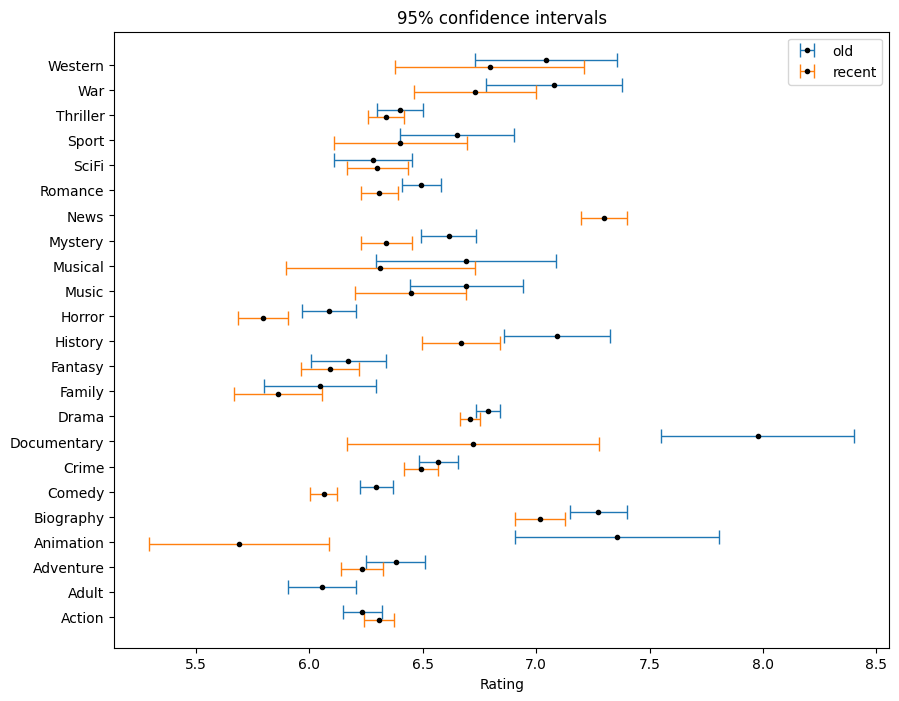

In [114]:
# Confidence interval according to the ratings
recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='averageRating')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='averageRating')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names, 'Rating')
plt.show()

Some genres show significant difference between the periods. In general, the old movies are better rated except for the action movies (but non-significant). Romance, Mystery, Horror, History, Documentary, Comedy, Biography, and Animation movies were significantly better rated before 2000. Are the movies worse, or is the population more critical? 

C:\Users\rache\AppData\Local\Temp\ipykernel_11876\3007343623.py:8: RuntimeWarning: Mean of empty slice
  means[n] = np.nanmean(data_new)
C:\Users\rache\AppData\Local\Temp\ipykernel_11876\3007343623.py:11: RuntimeWarning: Mean of empty slice
  return [np.nanmean(means), np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]


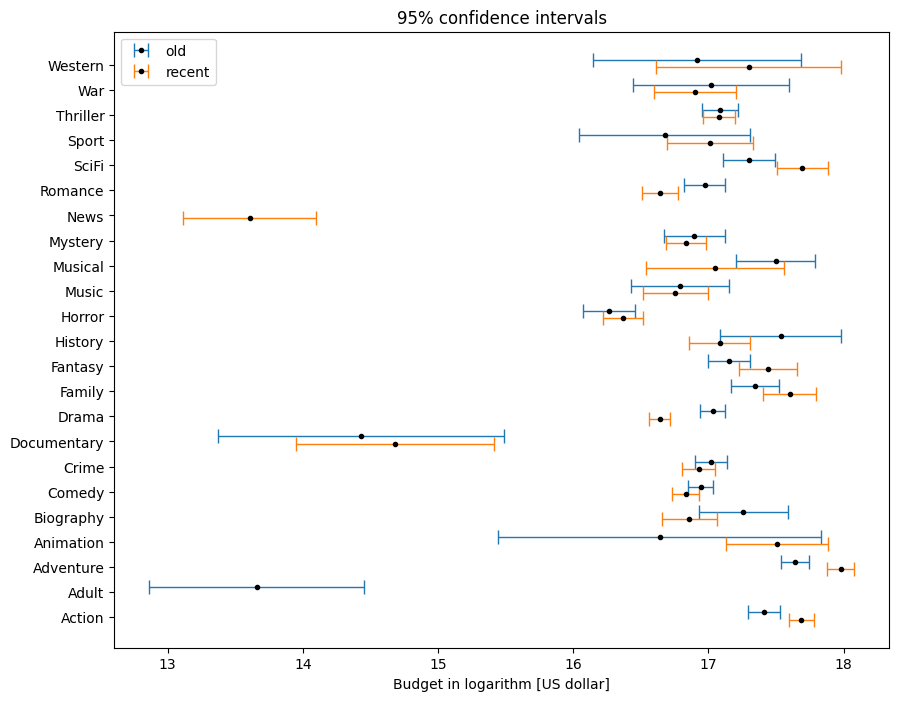

In [115]:
# Confidence interval according to the budget

recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='log_budget')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='log_budget')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names,  'Budget in logarithm [US dollar]')
plt.show()

Science fiction, Adventure, and Action movies show an significant increase in budget, whereas Romance and Drama movies undergo a significant decrease in their budget. 

C:\Users\rache\AppData\Local\Temp\ipykernel_11876\3007343623.py:8: RuntimeWarning: Mean of empty slice
  means[n] = np.nanmean(data_new)
C:\Users\rache\AppData\Local\Temp\ipykernel_11876\3007343623.py:11: RuntimeWarning: Mean of empty slice
  return [np.nanmean(means), np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]


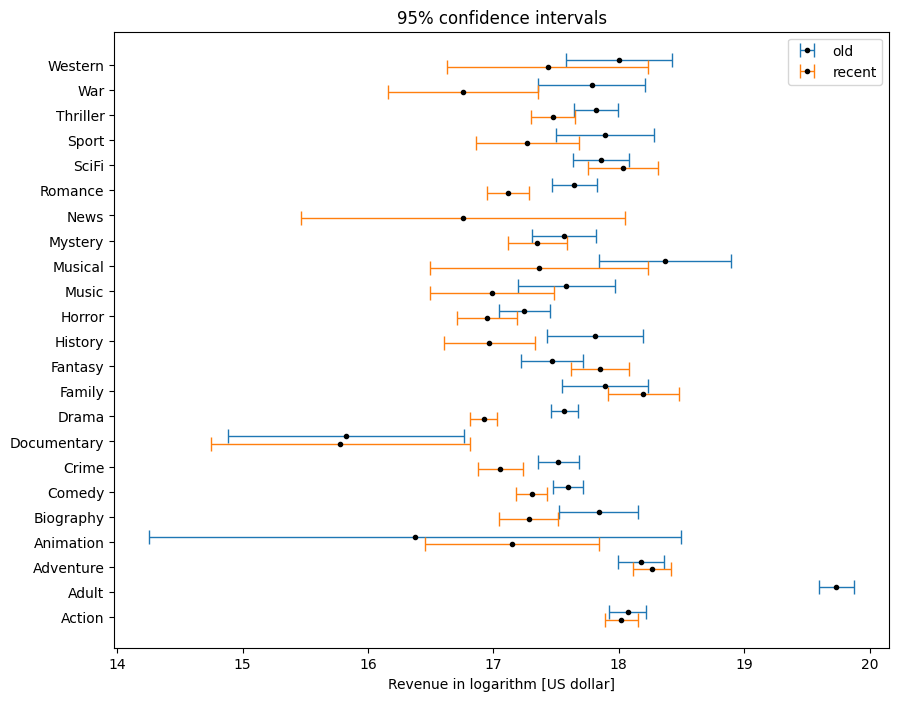

In [116]:
# Confidence interval according to the revenue

recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='log_revenue')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='log_revenue')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names,  'Revenue in logarithm [US dollar]')
plt.show()

No movie show significant increase in their revenue, whereas Romance, History, Drama, Crime, Comedy, and Biography movies have a significant decrease.
Thus, an significant increase in budget (such as for Action, Adventure, and Science fiction movies) does not mean an significant increase in the revenue.

In [117]:
old_movies['diff_log_rev_bud'] = old_movies.log_revenue-old_movies.log_budget
recent_movies['diff_log_rev_bud'] = recent_movies.log_revenue-recent_movies.log_budget
old_movies.head(2)

C:\Users\rache\AppData\Local\Temp\ipykernel_11876\1455148246.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  old_movies['diff_log_rev_bud'] = old_movies.log_revenue-old_movies.log_budget
C:\Users\rache\AppData\Local\Temp\ipykernel_11876\1455148246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_movies['diff_log_rev_bud'] = recent_movies.log_revenue-recent_movies.log_budget


,genre,date,averageRating,corr_budget,corr_revenue,Action,Adult,Adventure,Animation,Biography,...,News,Romance,SciFi,Sport,Thriller,War,Western,log_revenue,log_budget,diff_log_rev_bud
3850,"['Comedy', 'Drama', 'Fantasy']",1993.0,8.1,2.738616e+07,1.333818e+08,0,0,0,0,0,...,0,0,0,0,0,0,0,18.708726,17.125548,1.583178
3857,"['Adventure', 'Drama', 'History']",1995.0,7.7,9.246698e+07,3.091206e+08,0,0,1,0,0,...,0,0,0,0,0,0,0,19.549242,18.342362,1.206880


C:\Users\rache\AppData\Local\Temp\ipykernel_11876\3007343623.py:8: RuntimeWarning: Mean of empty slice
  means[n] = np.nanmean(data_new)
C:\Users\rache\AppData\Local\Temp\ipykernel_11876\3007343623.py:11: RuntimeWarning: Mean of empty slice
  return [np.nanmean(means), np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]
C:\Users\rache\anaconda3\envs\ada\lib\site-packages\numpy\lib\nanfunctions.py:1374: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(


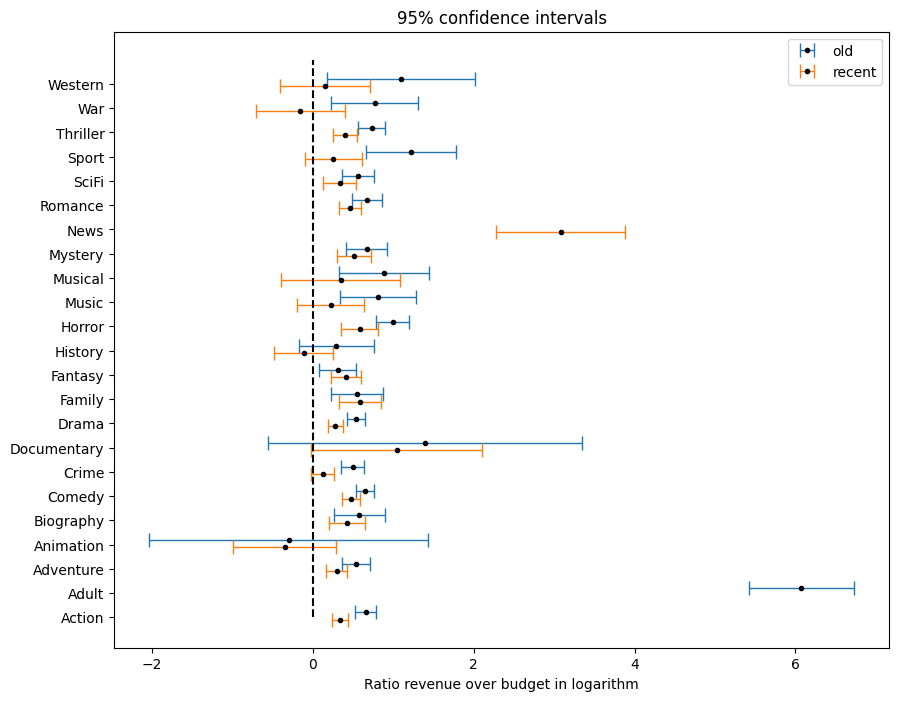

In [118]:
recent_CIs = []    
old_CIs = []    
    
for g in genre_names:
    difference_in_usage(old_movies, g=g, CI_list=old_CIs, measure='diff_log_rev_bud')
for g in genre_names:
    difference_in_usage(recent_movies, g=g, CI_list=recent_CIs, measure='diff_log_rev_bud')
    
plot_double_CIs(old_CIs, recent_CIs, genre_names, 'Ratio revenue over budget in logarithm')
plt.vlines(0, 0, 23, linestyle='--', color='black')
plt.show()

In general, the revenue is higher than the budget. No genre shows a significant higher budget (result below zero). Thriller, Sport, Drama, Crime, and Action had a significant higher difference between the budget and the revenue during the first period (before 2000). 
Western, War, Sport, Musical, Music, History, Documentary, Crime, and Animation movies, do not have significant higher revenue than budget.  